### This notebook is for checking day vs night euphausiid biomass to see if a correction factor is needed
###### Correction factor of 3 has been applied to adult euphausiid abundance/biomass in Mackas et al. 2013, Li et al. 2013,
###### Perry et al. 2021, Suchy et al. 2022 and was based on results from:
###### "Night versus day abundance estimates of zooplankton at two coastal stations in British Columbia, Canada"
###### (Shaw & Robinson 1998)
###### Notes re: this paper - OBLIQUE bongo tows were used at one station in Strait of Georgia and one station on west coast Vancouver Island

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict

import scipy.stats as stats

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline


## Import IOS Zooplankton data and create dataframe

In [66]:
ls '/ocean/ksuchy/MOAD/observe/Data and Code files for KS 2020dec11/2020_05_21 1995-2011 SoG VNH.csv'

'/ocean/ksuchy/MOAD/observe/Data and Code files for KS 2020dec11/2020_05_21 1995-2011 SoG VNH.csv'


In [67]:
df=pd.read_excel('/ocean/ksuchy/MOAD/observe/2007-2012_SoG_VNH.xlsx',engine='openpyxl')

In [68]:
df2=pd.read_excel('/ocean/ksuchy/MOAD/observe/2013-2015_SoG_VNH.xlsx',engine='openpyxl')

In [69]:
df3=pd.read_excel('/ocean/ksuchy/MOAD/observe/2016-2017_SoG_VNH.xlsx',engine='openpyxl')

In [70]:
df4=pd.read_excel('/ocean/ksuchy/MOAD/observe/2018-2019_SoG_VNH.xlsx',engine='openpyxl')

In [71]:
df5=pd.read_excel('/ocean/ksuchy/MOAD/observe/2020-2024_SoG_VNH.xlsx',engine='openpyxl')

In [72]:
df.keys()

Index(['Key', 'region_name', 'Station', 'PROJECT', 'lon', 'lat', 'Date',
       'STN_TIME', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'Net_Mouth_Dia(m)',
       'DEPTH_STRT1', 'DEPTH_END1', 'Bottom Depth(m)', 'Volume Filtered(m3)',
       'CTD', 'NOTES', 'PI', 'Phylum:', 'Class:', 'Order:', 'Family:', 'Name',
       'Abundance(#/m3)', 'Biomass(mg/m3)', 'NumberOfSpecies',
       'Station Diversity', 'Station Equitability'],
      dtype='object')

In [73]:
df2.keys()

Index(['Key', 'region_name', 'Station', 'PROJECT', 'lon', 'lat', 'Date',
       'STN_TIME', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'Net_Mouth_Dia(m)',
       'DEPTH_STRT1', 'DEPTH_END1', 'Bottom Depth(m)', 'Volume Filtered(m3)',
       'CTD', 'NOTES', 'PI', 'Phylum:', 'Class:', 'Order:', 'Family:', 'Name',
       'Abundance(#/m3)', 'Biomass(mg/m3)', 'NumberOfSpecies',
       'Station Diversity', 'Station Equitability'],
      dtype='object')

### Concatenate SoG dataframes into one 2007-2022

In [74]:
SoGDF=pd.concat([df,df2,df3,df4,df5], ignore_index=True)

In [75]:
SoGDF

,Key,region_name,Station,PROJECT,lon,lat,Date,STN_TIME,Twilight,Net_Type,...,Class:,Order:,Family:,Name,Abundance(#/m3),Biomass(mg/m3),NumberOfSpecies,Station Diversity,Station Equitability,Abundance(./m3)
0,IOS2007001013101,Central Strait of Georgia,GEO1,Str. Geo.,-123.75,49.250,2007-02-22,22:57:00,Night,Bongo VNH,...,Polychaeta,Aciculata,Tomopteridae,Tomopteris septentrionalis s2,2.40550,0.81787,39,2.404,0.657,NaN
1,IOS2007001013101,Central Strait of Georgia,GEO1,Str. Geo.,-123.75,49.250,2007-02-22,22:57:00,Night,Bongo VNH,...,Polychaeta,Aciculata,Tomopteridae,Tomopteris septentrionalis s3,0.25773,0.87629,39,2.404,0.657,NaN
2,IOS2007001013101,Central Strait of Georgia,GEO1,Str. Geo.,-123.75,49.250,2007-02-22,22:57:00,Night,Bongo VNH,...,Polychaeta,Canalipalpata,Spionidae,Spionidae *sp. larvae s1,4.12371,0.32990,39,2.404,0.657,NaN
3,IOS2007001013101,Central Strait of Georgia,GEO1,Str. Geo.,-123.75,49.250,2007-02-22,22:57:00,Night,Bongo VNH,...,Cirripedia,Thecostraca,NaN,Cirripedia *sp. nauplii s1,4.12371,0.16495,39,2.404,0.657,NaN
4,IOS2007001013101,Central Strait of Georgia,GEO1,Str. Geo.,-123.75,49.250,2007-02-22,22:57:00,Night,Bongo VNH,...,Malacostraca,Decapoda,Majidae,Majidae *sp. zoea s1,1.37457,0.30241,39,2.404,0.657,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248818,PSF2021098001901,Central Strait of Georgia,8BZ,Citizen Science,-123.35,49.338,2021-09-27,16:15:00,Daylight,Ring VNH,...,Hydrozoa,Trachylina,Rhopalonematidae,Aglantha digitale s2,0.78585,1.49312,32,2.459,0.710,NaN
248819,PSF2021098001901,Central Strait of Georgia,8BZ,Citizen Science,-123.35,49.338,2021-09-27,16:15:00,Daylight,Ring VNH,...,Hydrozoa,Trachylina,Rhopalonematidae,Aglantha digitale s3,0.19646,0.63261,32,2.459,0.710,NaN
248820,PSF2021098001901,Central Strait of Georgia,8BZ,Citizen Science,-123.35,49.338,2021-09-27,16:15:00,Daylight,Ring VNH,...,Gymnolaemata,NaN,NaN,Bryozoa *sp. cyphonautes s1,12.57367,0.01635,32,2.459,0.710,NaN
248821,PSF2021098001901,Central Strait of Georgia,8BZ,Citizen Science,-123.35,49.338,2021-09-27,16:15:00,Daylight,Ring VNH,...,Gastropoda,NaN,NaN,Gastropoda *sp. veligers s1,9.43026,0.02452,32,2.459,0.710,NaN


In [76]:
SoGDF['Biomass(mg/m3)']

0         0.81787
1         0.87629
2         0.32990
3         0.16495
4         0.30241
           ...   
248818    1.49312
248819    0.63261
248820    0.01635
248821    0.02452
248822    1.60314
Name: Biomass(mg/m3), Length: 248823, dtype: float64

In [77]:
SoGDF['region_name'].unique()

array(['Central Strait of Georgia', 'Northern Strait of Georgia',
       'Gulf Islands', 'Nearshore-Central West', 'Nearshore North West',
       'Baynes Sound', 'Nearshore-North East', 'Nearshore-Central East',
       'Southern Strait of Georgia', 'Juan de Fuca', 'Puget Sound',
       'Tidal Mixed', 'San Juan Islands'], dtype=object)

In [78]:
SoGDF['Net_Type'].unique()

array(['Bongo VNH', 'MPS VNH', 'SCOR VNH', 'Bongo ONH', 'NorPac VNH',
       'Ring VNH'], dtype=object)

### Convert date to proper format

In [79]:
SoGDF['Date'][0],SoGDF['STN_TIME'][0]

(Timestamp('2007-02-22 00:00:00'), datetime.time(22, 57))

In [80]:
SoGDF['Date'][1000:1020]

1000   2007-02-02
1001   2007-02-02
1002   2007-02-02
1003   2007-02-02
1004   2008-02-17
1005   2008-02-17
1006   2008-02-17
1007   2008-02-17
1008   2008-02-17
1009   2008-02-17
1010   2008-02-17
1011   2008-02-17
1012   2008-02-17
1013   2008-02-17
1014   2008-02-17
1015   2008-02-17
1016   2008-02-17
1017   2008-02-17
1018   2008-02-17
1019   2008-02-17
Name: Date, dtype: datetime64[ns]

In [81]:
SoGDF['Date']

0        2007-02-22
1        2007-02-22
2        2007-02-22
3        2007-02-22
4        2007-02-22
            ...    
248818   2021-09-27
248819   2021-09-27
248820   2021-09-27
248821   2021-09-27
248822   2021-09-27
Name: Date, Length: 248823, dtype: datetime64[ns]

In [82]:
SoGDF['Biomass(mg/m3)']=SoGDF['Biomass(mg/m3)'].fillna(0)

In [83]:
SoGDF.loc[SoGDF['region_name']=='Juan de Fuca',['Key','Date','Twilight','Order:','Name','Biomass(mg/m3)']].groupby(['Key','Date','Twilight','Order:','Name'],as_index=False)\
        .sum().sort_values(['Biomass(mg/m3)'],ascending=False).head(20)

,Key,Date,Twilight,Order:,Name,Biomass(mg/m3)
2771,IOS2021012000601,2021-09-08,Daylight,Euphausiacea,Thysanoessa raschii F,754.70856
2351,IOS2019062001301,2019-10-01,Daylight,Euphausiacea,Thysanoessa raschii F,305.05471
3066,IOS2022022000901,2022-08-26,Night,Euphausiacea,Thysanoessa raschii F,282.27491
137,IOS2015010000501,2015-08-20,Night,Euphausiacea,Thysanoessa raschii F,273.60551
3130,IOS2023026000801,2023-08-25,Night,Euphausiacea,Thysanoessa raschii F,167.83265
1228,IOS2017008000601,2017-08-16,Daylight,Euphausiacea,Thysanoessa raschii F,165.30830
761,IOS2016008000701,2016-08-17,Night,Euphausiacea,Thysanoessa raschii F,158.47335
1994,IOS2018040012501,2018-09-27,Night,Euphausiacea,Thysanoessa raschii F,147.73832
5251,PBS2022011016601,2022-10-21,Daylight,Euphausiacea,Thysanoessa raschii F,112.82111
1881,IOS2018032001401,2018-11-22,Night,Euphausiacea,Thysanoessa raschii F,95.30874


In [84]:
SoGDF.loc[SoGDF['region_name']=='Central Strait of Georgia',['Key','Date','Twilight','Order:','Name','Biomass(mg/m3)']].groupby(['Key','Date','Twilight','Order:','Name'],as_index=False)\
        .sum().sort_values(['Biomass(mg/m3)'],ascending=False).head(20)

,Key,Date,Twilight,Order:,Name,Biomass(mg/m3)
2582,DND2022098003401,2022-07-06,Daylight,Euphausiacea,Euphausia pacifica s3,274.72624
88669,PSF2021098000701,2021-03-24,Daylight,Decapoda,Cancridae *sp. zoea s1,191.71244
12659,IOS2013012001701,2013-04-11,Daylight,Calanoida,Neocalanus plumchrus 5,184.72304
689,DND2022098001001,2022-03-15,Daylight,Copelata,Oikopleura labradoriensis s3,172.19912
85343,PBS2010017043101,2010-07-07,Daylight,Euphausiacea,Euphausia pacifica F,156.58363
85206,PBS2010017042301,2010-07-07,Daylight,Euphausiacea,Euphausia pacifica F,139.40000
79866,PBS2008014001101,2008-06-18,Daylight,Euphausiacea,Euphausia pacifica F,133.47874
76752,IOS2024019021401,2024-05-26,Daylight,Calanoida,Neocalanus plumchrus 5,118.17143
12847,IOS2013012002501,2013-04-11,Daylight,Copelata,Oikopleura dioica s1,102.55422
13344,IOS2013013005001,2013-06-30,Night,Euphausiacea,Euphausia pacifica F,96.63426


In [85]:
#create new columns
SoGDF['Year']=[ii.year for ii in SoGDF['Date']]
SoGDF['Month']=[ii.month for ii in SoGDF['Date']]
SoGDF['YD']=et.datetimeToYD(SoGDF['Date'])
SoGDF['YMo']=SoGDF['Date'].dt.strftime('%Y-%m')

## Start by looking at Euphausiid biomass in all samples (Bongo, SCOR, and Ring VNH (vertical net haul) only!)
#### - compare to results from oblique bongo tows in Shawn & Robinson 1998

In [86]:
SoGDayALLsamples=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')]

In [87]:
SoGNightALLsamples=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')]

In [88]:
from IPython.display import Image

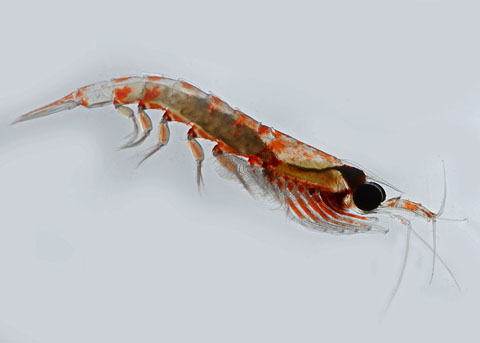

In [89]:
PATH = "/ocean/ksuchy/MOAD/analysis-karyn/notebooks/MHW/Obs_Groundtruthing/"
Image(filename = PATH + "Euphausiapacifica.jpeg", width=400, height=400)

Text(0.5, 1.0, 'Euphausiid Biomass - All Regions')

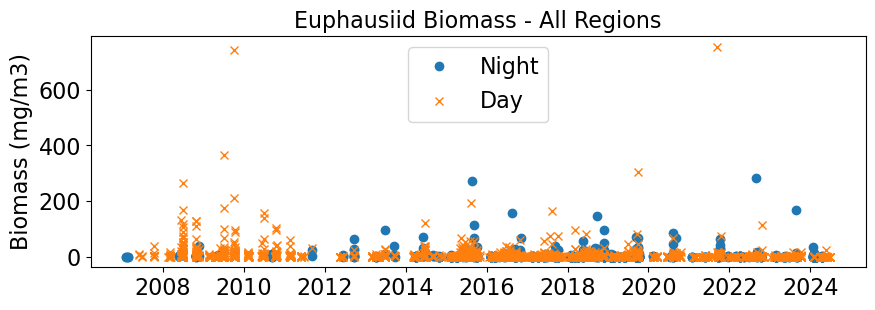

In [90]:
fig, ax = plt.subplots(figsize=(10,3))


ax.plot(SoGNightALLsamples['Date'],SoGNightALLsamples['Biomass(mg/m3)'],linestyle='',marker='o',label='Night')
ax.plot(SoGDayALLsamples['Date'],SoGDayALLsamples['Biomass(mg/m3)'],linestyle='',marker='x',label='Day')
ax.legend()
#ax.set_xlim(2006.5, 2022.5)
ax.set_ylabel('Biomass (mg/m3)')
ax.set_title('Euphausiid Biomass - All Regions')

In [91]:
SoGDayALLsamples_mean=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Name.str.contains('F')\
                &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .mean()

In [92]:
SoGDayALLsamples_std=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Name.str.contains('F')\
                &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .std()

In [93]:
SoGNightALLsamples_mean=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Name.str.contains('F')\
                &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .mean()

In [94]:
SoGNightALLsamples_std=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Name.str.contains('F')\
                &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .std()

Text(0.5, 1.0, 'Euphausiid Biomass - All Regions')

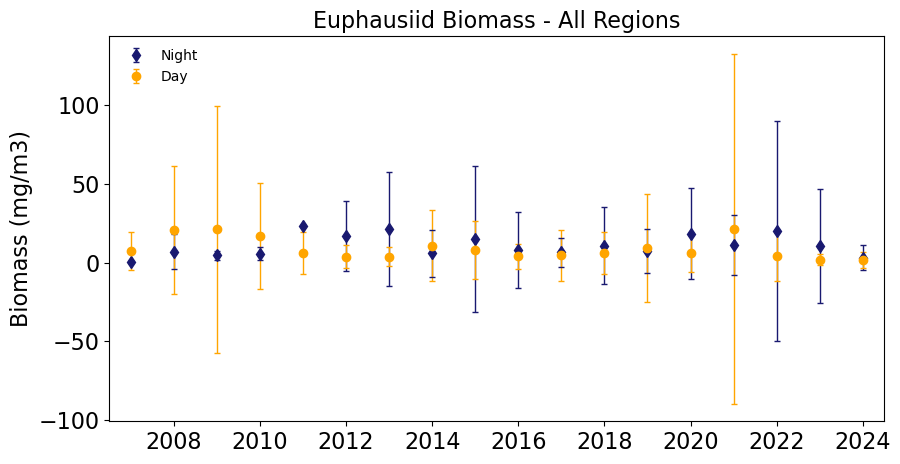

In [95]:
fig, ax = plt.subplots(figsize=(10,5))

ax.errorbar(SoGNightALLsamples_mean['Year'],SoGNightALLsamples_mean['Biomass(mg/m3)'],yerr=SoGNightALLsamples_std['Biomass(mg/m3)'],fmt='d',color='midnightblue',ecolor = 'midnightblue', elinewidth = 1, capsize = 2,label='Night')
ax.errorbar(SoGDayALLsamples_mean['Year'],SoGDayALLsamples_mean['Biomass(mg/m3)'],yerr=SoGDayALLsamples_std['Biomass(mg/m3)'],fmt='o',color='orange',ecolor = 'orange', elinewidth = 1, capsize = 2,label='Day')


#ax.plot(SoGNightALLsamples_mean['Year'],SoGNightALLsamples_mean['Biomass(mg/m3)'],linestyle='',marker='o',label='Night')
#ax.plot(SoGNightALLsamples_mean['Year'],SoGDayALLsamples_mean['Biomass(mg/m3)'],linestyle='',marker='x',label='Day')
ax.legend(loc=2,frameon=False,fontsize=10)
ax.set_xlim(2006.5, 2024.5)
ax.set_ylabel('Biomass (mg/m3)')
ax.set_title('Euphausiid Biomass - All Regions')

Text(0.5, 1.0, 'Euphausiid Biomass Night:Day - All Regions')

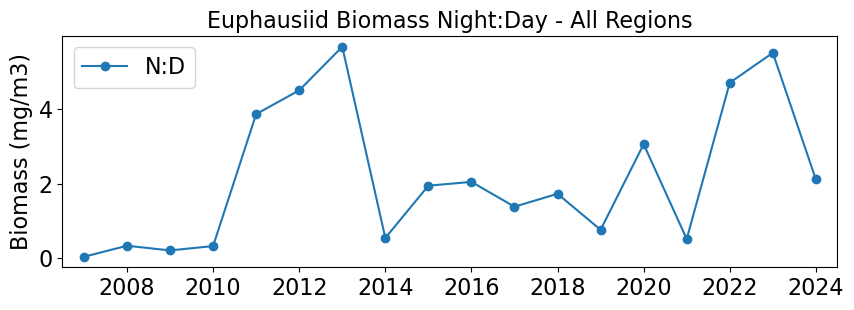

In [96]:
fig, ax = plt.subplots(figsize=(10,3))


ax.plot(SoGNightALLsamples_mean['Year'],SoGNightALLsamples_mean['Biomass(mg/m3)']/(SoGDayALLsamples_mean['Biomass(mg/m3)']),linestyle='-',marker='o',label='N:D')

ax.legend()
ax.set_xlim(2006.5, 2024.5)
ax.set_ylabel('Biomass (mg/m3)')
ax.set_title('Euphausiid Biomass Night:Day - All Regions')

In [97]:
(SoGNightALLsamples_mean['Biomass(mg/m3)']/SoGDayALLsamples_mean['Biomass(mg/m3)']).mean()

2.181758257198603

In [98]:
(SoGNightALLsamples_mean['Biomass(mg/m3)']/SoGDayALLsamples_mean['Biomass(mg/m3)']).min()

0.04383921108451194

In [99]:
(SoGNightALLsamples_mean['Biomass(mg/m3)']/SoGDayALLsamples_mean['Biomass(mg/m3)']).max()

5.664894494996104

#### Night:Day ranged between 0.04 and 5.66 with a mean of 2.18 - but this considers the mean only and not the error about the mean

### Test differences between night and day samples

In [129]:
from scipy.stats import f_oneway

In [130]:
# Conduct the one-way ANOVA
f_oneway(SoGNightALLsamples_mean['Biomass(mg/m3)'],SoGDayALLsamples_mean['Biomass(mg/m3)'])

F_onewayResult(statistic=0.9045832100909709, pvalue=0.34826826747078066)

In [100]:
stats.ttest_ind(a=SoGNightALLsamples_mean['Biomass(mg/m3)'], b=SoGDayALLsamples_mean['Biomass(mg/m3)'], equal_var=True)

Ttest_indResult(statistic=0.9510957943819176, pvalue=0.34826826747078043)

#### Would be interesting to follow-up looking at the correlations between euphausiid abundance from observatins and tidal height, ambient light during sampling (PAR) from the model for a given sampling time, and intensity of moonlight (see results in Shaw & Robinson 1998) 

## What happens when I run the analysis with only Bongo Vertical Net Hauls?

In [101]:
BongoDay_mean=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Name.str.contains('F')\
                &SoGDF.Net_Type.str.contains('Bongo VNH')].groupby(['Year'],as_index=False)\
        .mean()

In [102]:
BongoDay_std=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Name.str.contains('F')\
                &SoGDF.Net_Type.str.contains('Bongo VNH')].groupby(['Year'],as_index=False)\
        .std()

In [103]:
BongoNight_mean=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Name.str.contains('F')\
                &SoGDF.Net_Type.str.contains('Bongo VNH')].groupby(['Year'],as_index=False)\
        .mean()

In [104]:
BongoNight_std=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Name.str.contains('F')\
                &SoGDF.Net_Type.str.contains('Bongo VNH')].groupby(['Year'],as_index=False)\
        .std()

Text(0.5, 1.0, 'Euphausiid Biomass in Bongo Nets Only - All Regions')

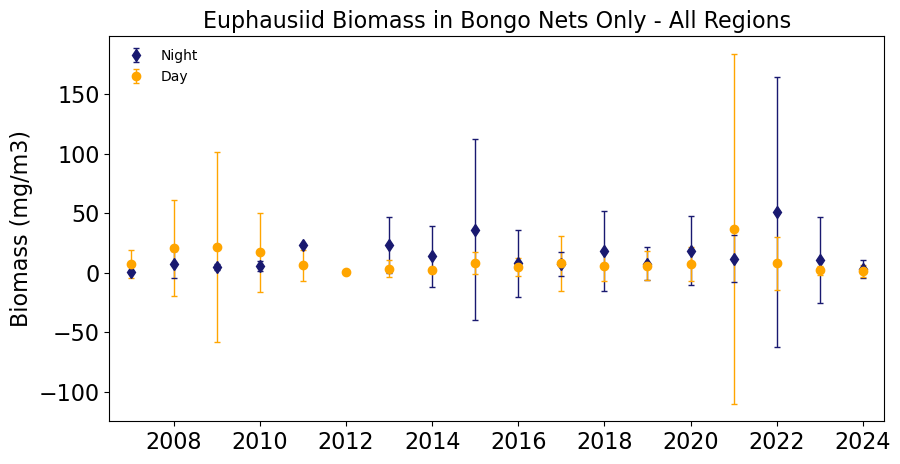

In [105]:
fig, ax = plt.subplots(figsize=(10,5))

ax.errorbar(BongoNight_mean['Year'],BongoNight_mean['Biomass(mg/m3)'],yerr=BongoNight_std['Biomass(mg/m3)'],fmt='d',color='midnightblue',ecolor = 'midnightblue', elinewidth = 1, capsize = 2,label='Night')
ax.errorbar(BongoDay_mean['Year'],BongoDay_mean['Biomass(mg/m3)'],yerr=BongoDay_std['Biomass(mg/m3)'],fmt='o',color='orange',ecolor = 'orange', elinewidth = 1, capsize = 2,label='Day')


#ax.plot(SoGNightALLsamples_mean['Year'],SoGNightALLsamples_mean['Biomass(mg/m3)'],linestyle='',marker='o',label='Night')
#ax.plot(SoGNightALLsamples_mean['Year'],SoGDayALLsamples_mean['Biomass(mg/m3)'],linestyle='',marker='x',label='Day')
ax.legend(loc=2,frameon=False,fontsize=10)
ax.set_xlim(2006.5, 2024.5)
ax.set_ylabel('Biomass (mg/m3)')
ax.set_title('Euphausiid Biomass in Bongo Nets Only - All Regions')

In [106]:
BongoDay_mean['Biomass(mg/m3)']

0      7.251271
1     20.513738
2     21.528236
3     16.942752
4      6.053062
5      0.212057
6      3.441324
7      2.107168
8      8.153015
9      4.652365
10     7.690216
11     5.478389
12     5.883715
13     7.453772
14    36.865950
15     7.726317
16     2.037125
17     1.495023
Name: Biomass(mg/m3), dtype: float64

In [107]:
BongoNight_mean['Biomass(mg/m3)']

0      0.365120
1      6.955024
2      4.502555
3      5.602765
4     23.384320
5     23.523995
6     13.752814
7     36.022053
8      7.747817
9      7.094557
10    18.306808
11     7.326320
12    18.341116
13    11.765174
14    51.078785
15    10.373782
16     3.158610
Name: Biomass(mg/m3), dtype: float64

### t tests for differences between night and day samples

In [108]:
stats.ttest_ind(a=BongoNight_mean['Biomass(mg/m3)'], b=BongoDay_mean['Biomass(mg/m3)'], equal_var=True)

Ttest_indResult(statistic=1.4374150094551879, pvalue=0.1600153156288232)

## Look at specific regions

In [109]:
CSoGDay=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')&(SoGDF['region_name']=='Central Strait of Georgia')\
                 &SoGDF.Name.str.contains('F|M')\
                 &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .mean()

In [110]:
CSoGDay_std=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')&(SoGDF['region_name']=='Central Strait of Georgia')\
                 &SoGDF.Name.str.contains('F|M')\
                     &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .std()

In [111]:
CSoGNight=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')&(SoGDF['region_name']=='Central Strait of Georgia')\
                   &SoGDF.Name.str.contains('F|M')\
                   &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .mean()

In [112]:
CSoGNight_std=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')&(SoGDF['region_name']=='Central Strait of Georgia')\
                   &SoGDF.Name.str.contains('F|M')\
                       &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .std()

Text(0.5, 1.0, 'Central Strait of Georgia')

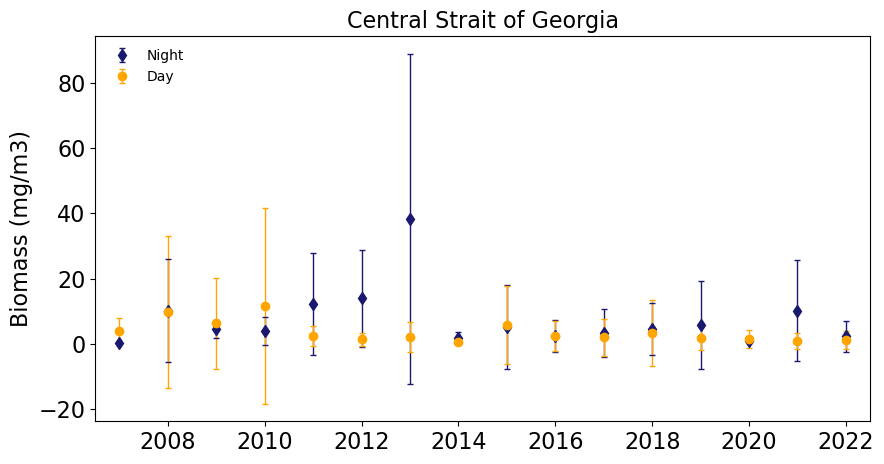

In [113]:
fig, ax = plt.subplots(figsize=(10,5))

ax.errorbar(CSoGNight['Year'],CSoGNight['Biomass(mg/m3)'],yerr=CSoGNight_std['Biomass(mg/m3)'],fmt='d',color='midnightblue',ecolor = 'midnightblue', elinewidth = 1,capsize=2, label='Night')
ax.errorbar(CSoGDay['Year'],CSoGDay['Biomass(mg/m3)'],yerr=CSoGDay_std['Biomass(mg/m3)'],fmt='o',color='orange',ecolor = 'orange', elinewidth = 1,capsize=2, label='Day')

ax.legend(loc=2,frameon=False,fontsize=10)
ax.set_xlim(2006.5, 2022.5)
ax.set_ylabel('Biomass (mg/m3)')
ax.set_title('Central Strait of Georgia')

### Test for differences between night and day samples

In [114]:
stats.ttest_ind(a=CSoGNight['Biomass(mg/m3)'], b=CSoGDay['Biomass(mg/m3)'], equal_var=True)

Ttest_indResult(statistic=1.5459648595204893, pvalue=0.13137136197507002)

In [131]:
# Conduct the one-way ANOVA
f_oneway(CSoGNight['Biomass(mg/m3)'],CSoGDay['Biomass(mg/m3)'])

F_onewayResult(statistic=2.390007346872207, pvalue=0.13137136197506943)

### Then look at individual samples containing Euphausiids in the Central SoG

In [115]:
CSoGDayALLsamples=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')&(SoGDF['region_name']=='Central Strait of Georgia')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')]

In [116]:
CSoGNightALLsamples=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')&(SoGDF['region_name']=='Central Strait of Georgia')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')]

Text(0.5, 1.0, 'Central Strait of Georgia')

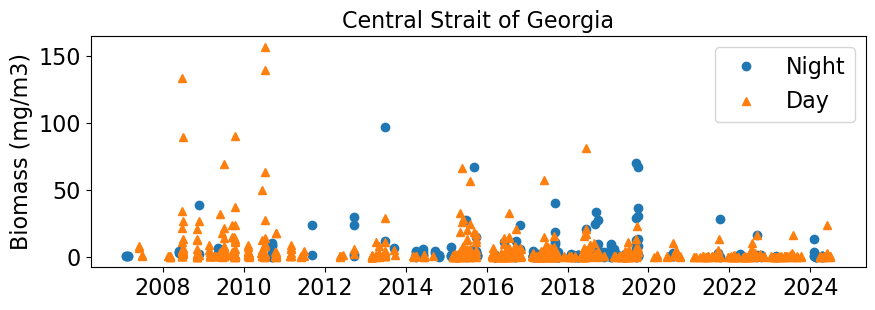

In [117]:
fig, ax = plt.subplots(figsize=(10,3))


ax.plot(CSoGNightALLsamples['Date'],CSoGNightALLsamples['Biomass(mg/m3)'],linestyle='',marker='o',label='Night')
ax.plot(CSoGDayALLsamples['Date'],CSoGDayALLsamples['Biomass(mg/m3)'],linestyle='',marker='^',label='Day')
ax.legend()
#ax.set_xlim(2006.5, 2022.5)
ax.set_ylabel('Biomass (mg/m3)')
ax.set_title('Central Strait of Georgia')

### t tests for differences between night and day samples

In [118]:
stats.ttest_ind(a=CSoGNightALLsamples['Biomass(mg/m3)'], b=CSoGDayALLsamples['Biomass(mg/m3)'], equal_var=True)

Ttest_indResult(statistic=1.0012402263749205, pvalue=0.3169257957096847)

In [132]:
# Conduct the one-way ANOVA
f_oneway(CSoGNightALLsamples['Biomass(mg/m3)'],CSoGDayALLsamples['Biomass(mg/m3)'])

F_onewayResult(statistic=1.0024819909113016, pvalue=0.3169257957095267)

## Now for Juan de Fuca

In [119]:
JdFDay=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')&(SoGDF['region_name']=='Juan de Fuca')\
                 &SoGDF.Name.str.contains('F|M')\
                &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .mean()

In [120]:
JdFDay_std=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')&(SoGDF['region_name']=='Juan de Fuca')\
                 &SoGDF.Name.str.contains('F|M')\
                    &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .std()

In [121]:
JdFNight=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')&(SoGDF['region_name']=='Juan de Fuca')\
                   &SoGDF.Name.str.contains('F|M')\
                  &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .mean()

In [122]:
JdFNight_std=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')&(SoGDF['region_name']=='Juan de Fuca')\
                   &SoGDF.Name.str.contains('F|M')\
                       &SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')].groupby(['Year'],as_index=False)\
        .std()

Text(0.5, 1.0, 'Juan de Fuca')

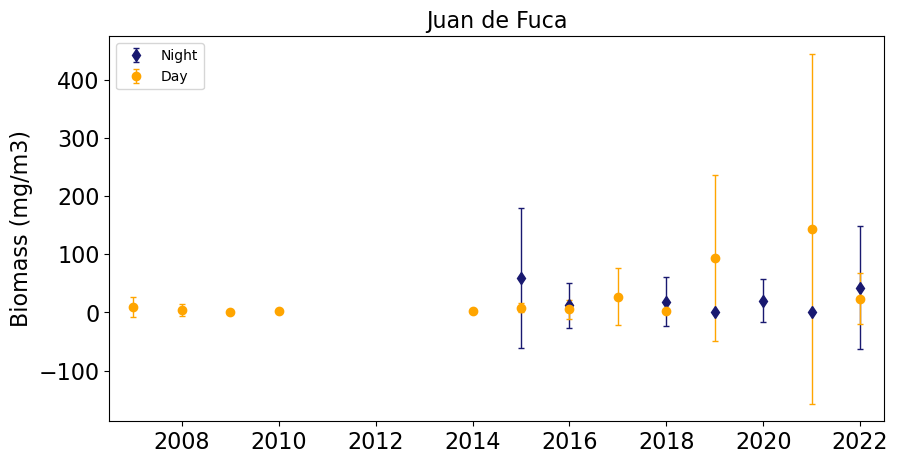

In [123]:
fig, ax = plt.subplots(figsize=(10,5))

ax.errorbar(JdFNight['Year'],JdFNight['Biomass(mg/m3)'],yerr=JdFNight_std['Biomass(mg/m3)'],fmt='d',color='midnightblue',ecolor = 'midnightblue', elinewidth = 1,capsize=2, label='Night')
ax.errorbar(JdFDay['Year'],JdFDay['Biomass(mg/m3)'],yerr=JdFDay_std['Biomass(mg/m3)'],fmt='o',color='orange',ecolor = 'orange', elinewidth = 1,capsize=2, label='Day')

ax.legend(loc=2,frameon=True,fontsize=10)
ax.set_xlim(2006.5, 2022.5)
ax.set_ylabel('Biomass (mg/m3)')
ax.set_title('Juan de Fuca')

### t tests for differences between night and day samples

In [124]:
stats.ttest_ind(a=JdFNight['Biomass(mg/m3)'], b=JdFDay['Biomass(mg/m3)'], equal_var=True)

Ttest_indResult(statistic=-0.3287884094279289, pvalue=0.7459119329852701)

In [125]:
JdFDayALLsamples=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Daylight')&(SoGDF['region_name']=='Juan de Fuca')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')]

In [126]:
JdFNightALLsamples=SoGDF.loc[(SoGDF['Order:']=='Euphausiacea')&(SoGDF['Twilight']=='Night')&(SoGDF['region_name']=='Juan de Fuca')\
                 &SoGDF.Name.str.contains('F|M')&SoGDF.Net_Type.str.contains('Bongo VNH|SCOR VNH|Ring VNH')]

Text(0.5, 1.0, 'Juan de Fuca')

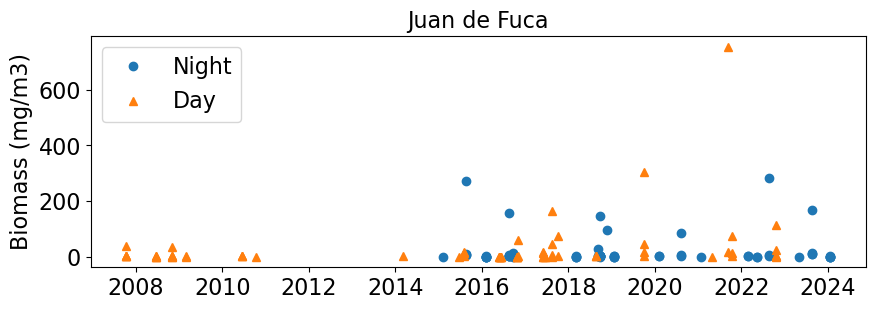

In [127]:
fig, ax = plt.subplots(figsize=(10,3))


ax.plot(JdFNightALLsamples['Date'],JdFNightALLsamples['Biomass(mg/m3)'],linestyle='',marker='o',label='Night')
ax.plot(JdFDayALLsamples['Date'],JdFDayALLsamples['Biomass(mg/m3)'],linestyle='',marker='^',label='Day')
ax.legend()
#ax.set_xlim(2006.5, 2022.5)
ax.set_ylabel('Biomass (mg/m3)')
ax.set_title('Juan de Fuca')

### t tests for differences between night and day samples

In [128]:
stats.ttest_ind(a=JdFNightALLsamples['Biomass(mg/m3)'], b=JdFDayALLsamples['Biomass(mg/m3)'], equal_var=True)

Ttest_indResult(statistic=-0.4010298981503661, pvalue=0.6890368608481725)